<a href="https://colab.research.google.com/github/Krukalex/Universal-Sentence-Encoder-using-URL-data/blob/main/USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General Notes
- this code runs and performs it's intended task
  - however, this data is run using all of the urls scraped from the asos site, and in practice one would need to have two seperate datasets, one for 404 urls and one for working urls, and would need to map them to each other
- one thing that may need to be revisted is the process for extracting the text that we actually want to use for the url
  - for instance, I included the asos.com at the beginning of each url, but a strong argument could be made that this should not be included since all of them have it anyway and could be confused for undue similarity
  - additionally, a lot of the websites have a strange 'cat' extension on the end of their url. I am not sure exactly what it is or why it is part of the website path, but this could likely be removed by implementing some regular expressions if i were so inclined
- One thing that i also considered is converting the strings generated for each url to a set to remove duplicates, since many duplicates seem to be present


Note on implementation use cases
- this can be used for things such as 404 url mapping, where we would determine which urls were most similar to the 404 one to determine where best to redirct the user
- it could also be used for general keyword mapping to make sure your keywords are relevant to the page they correspond to 
  - note that this would require a data set of urls and keywords, instead of 404 urls and working urls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/'Data science'/

/content/drive/MyDrive/Data science


In [ ]:
import pandas as pd

In [ ]:
#we will need to isolate the text from all of the urls
#will need to use regex

import re

In [ ]:
sitemap=pd.read_xml('sitemap.xml')

In [ ]:
sitemap.columns=['URL', 'lastmod', 'priority']

In [ ]:
sitemap.head()

,URL,lastmod,priority
0,https://www.asos.com/?,2022-11-04T23:56:56+00:00,1.0
1,https://www.asos.com/customer-care/,2022-11-04T23:56:56+00:00,0.8
2,https://www.asos.com/,2022-11-04T23:56:56+00:00,0.8
3,https://www.asos.com/women/,2022-11-04T23:56:56+00:00,0.8
4,https://www.asos.com/men/,2022-11-04T23:56:56+00:00,0.8


Need to extract the host name and the path from each of these urls, strip them of special characters and add them as a new column in the dataframe

Here is a proof of concept for one row

In [ ]:
sitemap['URL'][100]

'https://www.asos.com/women/workwear/cat/?cid=19645&refine=attribute_1047:8416'

In [ ]:
from urllib.parse import urlparse
path = urlparse(sitemap['URL'][0])[1:3]
path



('www.asos.com', '/')

In [ ]:
path[0]+path[1]

'www.asos.com/'

Will attempt to implement lambda function to do this for every row

In [ ]:
def get_path(x):
  path = urlparse(x)[1:3]
  return(path)

In [ ]:
x=get_path(sitemap['URL'][1])[0]+get_path(sitemap['URL'][1])[1]

In [ ]:
x

'www.asos.com/customer-care/'

In [ ]:
#this is ugly but it works, combines all of the steps laid out above in one long function
#there may be a more elegant implementation of this

sitemap['string']=sitemap['URL'].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", get_path(x)[0]+get_path(x)[1])))

We now have all of the urls formatted as sentences instead of html links. Now we will need to pass them into the universal sentence encoder

In [ ]:
%%capture
!pip3 install seaborn

In [ ]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def plot_similarity(labels, features, rotation):
  #when the inner product is calculated for 2 nxp matrices inputs, the output is an nxn array, with each number being the similarity score between the sentence in the column and the row
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

#try doing a visualization for the first 5 urls

Nice visual, but what we really want are the N most similar URLs for any given input

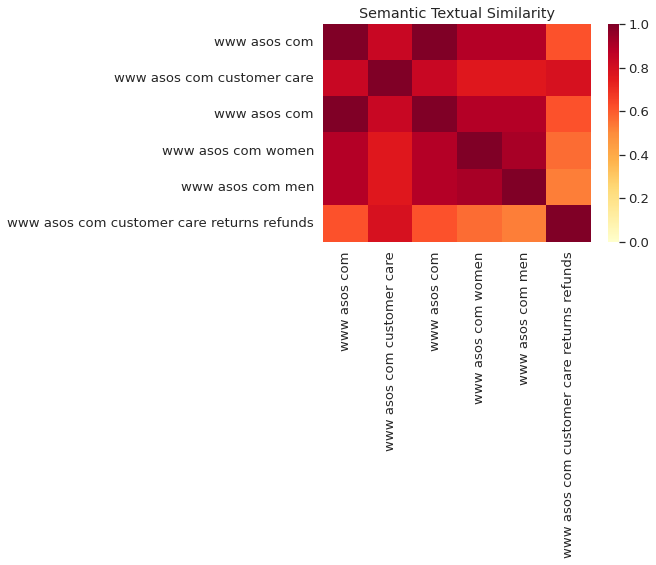

In [ ]:
#not particularly helpful for our purposes but it shows that the algorithm is working as intended
#for example we can see that customer care returns refunds is most similar to customer care, which is what we expect
#might consider not using the host name since all of these will have some level of similarty since they are all www.asos.com

run_and_plot(sitemap['string'][0:6])

In [ ]:
#got this code from:
#https://www.searchenginejournal.com/map-404-urls-at-scale-sentence-embeddings/
## I did however make some modifications to this code, so it will not look exactly how the sample code on the linked website does
#returns to top 5 closest matching urls, the similarity score, and the index of the url

import heapq

TOP_N = 5
BEST_ONLY = False
THRESHOLD_PROBABILITY = 0.65

def get_similarity_suggestion(phrase, all_phrases, no_percentage=False):
  message_embeddings_ = embed(all_phrases) #embed the vector of all phraes 
  phrase_embeddings= embed(phrase) #embed the specific phrase in question
  result = np.inner(phrase_embeddings, message_embeddings_) #1x500 array, with a score for the similarity between phrase in question with all 500 phrases in the dataset
  result=result.reshape(result.shape[1], result.shape[0]) #for some reason it only works if you reshape the array from 1x500 to 500x1


  top_N_indexes = heapq.nlargest(TOP_N, range(len(result)), result.take) #finds the indices of the top 5 scores

  #iterate through the indices to find their associated url and semantic similarity score
  to_return = list()
  for i in top_N_indexes:
      matched = sitemap['URL'].iloc[i]
      if no_percentage:
          to_return.append(matched['phrase'])
      else:
          to_return.append([str(matched), '%.2f' % float(result.take([i])*100), i])
  return to_return

Example of this code in action

In [ ]:
sitemap['string'][100:101]

100    www asos com women workwear cat
Name: string, dtype: object

In [ ]:
#top 5 results, with their url, sematic similarity score, and their index in the dataframe

get_similarity_suggestion(sitemap['string'][100:101], sitemap['string'])

[['https://www.asos.com/women/workwear/cat/?cid=19645', '100.00', 81],
 ['https://www.asos.com/women/workwear/cat/?cid=19645&refine=attribute_1047:8416',
  '100.00',
  100],
 ['https://www.asos.com/women/loungewear/cat/?cid=21867', '94.41', 65],
 ['https://www.asos.com/women/multipacks/cat/?cid=19224', '93.31', 66],
 ['https://www.asos.com/women/tracksuits/cat/?cid=27953', '92.83', 55]]